In [1]:
%load_ext lab_black

In [2]:
import os
import sys

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import xarray as xr
from cmcrameri import cm
from hydra import compose, initialize
from omegaconf import OmegaConf, DictConfig
from scipy.optimize import differential_evolution
from sklearn import preprocessing

sys.path.append("../")
from cfg.convert_cfg_to_yaml import save_myyaml_from_mycfg
from Data import Data_eval
import Data
from include.loss import pixel_weighted_cross_entropy
import model_eval
import models.reg as rm
import seaborn as sns


import matplotlib_functions as mympf

mympf.setMatplotlibParam()
plt.viridis()

dir_res = "/cerea_raid/users/dumontj/dev/coco2/dl/weights"
dir_plots = "pres-inv"

2023-10-12 15:34:42.907768: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-12 15:34:42.907807: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-12 15:34:42.907849: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-12 15:34:42.915060: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<Figure size 1920x1440 with 0 Axes>

# Inv et seg

In [64]:
fig3_ds = "S_pJan"
ds = xr.open_dataset(
    f"/libre/dumontj/coco2/dl-input/{fig3_ds}/2d_train_valid_dataset.nc"
)

In [65]:
idx0 = int(np.random.uniform(0, len(ds.idx_img)))
idx0 = 2769
ds_idx = ds.isel(idx_img=idx0)
print("idx:", idx0)
print("origin:", ds_idx.point_source.values)
print("time:", ds_idx.time.values)
print("emiss:", ds_idx.emiss.values)

idx: 2769
origin: smart_pJan_nBJan
time: 2015-05-14T09:00:00.000000000
emiss: [38.43853 37.49335 34.02767 28.98667 25.20588 23.31533]


<Figure size 1920x1440 with 0 Axes>

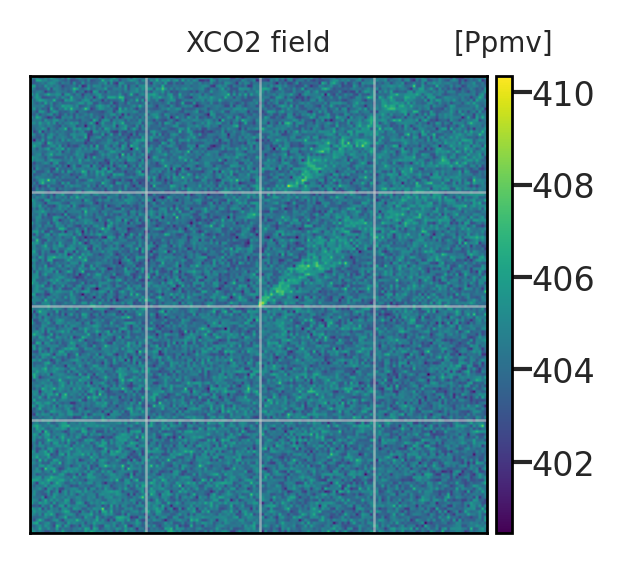

In [69]:
plt.viridis()
axs = mympf.set_figure_axs(
    1,
    1,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.01,
    pad_w_ext_right=0.15,
    pad_w_int=0.2,
    pad_h_ext=0.2,
    pad_h_int=0.25,
)

im0 = axs[0].imshow(np.squeeze(ds.xco2[idx0].values) + np.random.randn(160, 160))
cax0 = axs[0].inset_axes((1.02, 0, 0.035, 1))
axs[0].set_xticks([40, 80, 120])
axs[0].set_yticks([40, 80, 120])
axs[0].set_xticklabels([])
axs[0].set_yticklabels([])
axs[0].set_title("XCO2 field")
cbar0 = plt.colorbar(im0, cax0, orientation="vertical")
cbar0.ax.tick_params(labelsize="8")
cbar0.ax.set_title("[Ppmv]")
plt.savefig(os.path.join(dir_plots, "XCO2_inv_seg.png"), transparent=True)

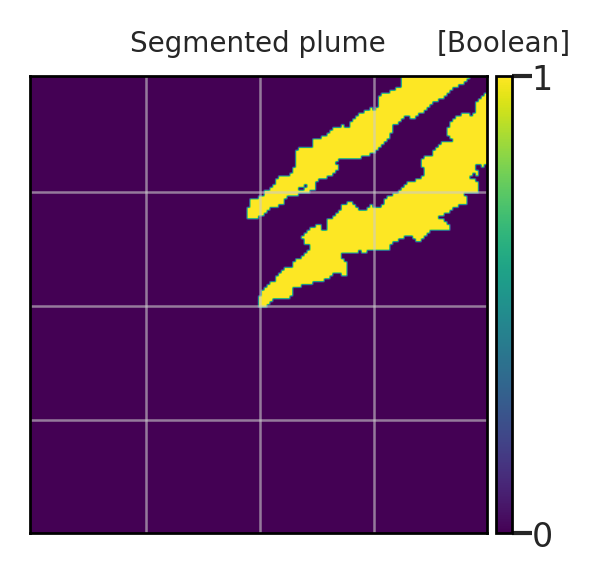

In [68]:
axs = mympf.set_figure_axs(
    1,
    1,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.01,
    pad_w_ext_right=0.15,
    pad_w_int=0.2,
    pad_h_ext=0.2,
    pad_h_int=0.25,
)

im0 = axs[0].imshow(np.where(np.squeeze(ds.plume[idx0].values) > 0, 1, 0))
cax0 = axs[0].inset_axes((1.02, 0, 0.035, 1))
axs[0].set_xticks([40, 80, 120])
axs[0].set_yticks([40, 80, 120])
axs[0].set_xticklabels([])
axs[0].set_yticklabels([])
axs[0].set_title("Segmented plume")
cbar0 = plt.colorbar(im0, cax0, orientation="vertical", ticks=[0, 1])
cbar0.ax.tick_params(labelsize="8")
cbar0.ax.set_title("[Boolean]")
plt.savefig(os.path.join(dir_plots, "seg_inv.png"), transparent=True)

# Where is the plume

In [20]:
fig3_ds = "S_pBer"
ds = xr.open_dataset(
    f"/libre/dumontj/coco2/dl-input/{fig3_ds}/2d_train_valid_dataset.nc"
)

In [21]:
idx0 = int(np.random.uniform(0, len(ds.idx_img)))
idx0 = 2883
ds_idx = ds.isel(idx_img=idx0)
print("idx:", idx0)
print("origin:", ds_idx.point_source.values)
print("time:", ds_idx.time.values)
print("emiss:", ds_idx.emiss.values)

idx: 2883
origin: smart_pBer_nBBer
time: 2015-05-21T03:00:00.000000000
emiss: [8.138228 7.341655 7.157905 7.644752 8.319039 9.249243]


<Figure size 1920x1440 with 0 Axes>

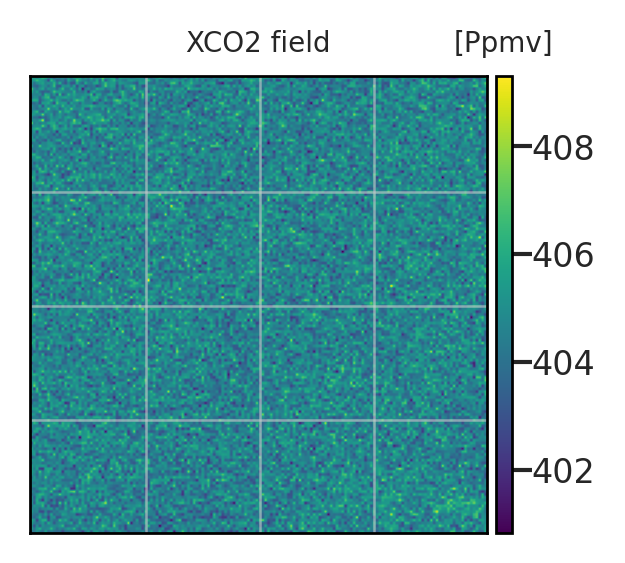

In [29]:
plt.viridis()
axs = mympf.set_figure_axs(
    1,
    1,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.01,
    pad_w_ext_right=0.15,
    pad_w_int=0.2,
    pad_h_ext=0.2,
    pad_h_int=0.25,
)

im0 = axs[0].imshow(np.squeeze(ds.xco2[idx0].values) + np.random.randn(160, 160))
cax0 = axs[0].inset_axes((1.02, 0, 0.035, 1))
axs[0].set_xticks([40, 80, 120])
axs[0].set_yticks([40, 80, 120])
axs[0].set_xticklabels([])
axs[0].set_yticklabels([])
axs[0].set_title("XCO2 field")
cbar0 = plt.colorbar(im0, cax0, orientation="vertical")
cbar0.ax.tick_params(labelsize="8")
cbar0.ax.set_title("[Ppmv]")
plt.savefig(os.path.join(dir_plots, "XCO2_field.png"), transparent=True)

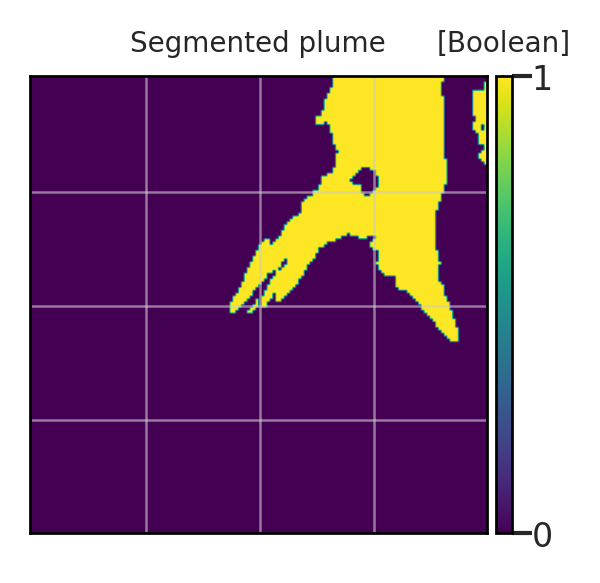

In [30]:
axs = mympf.set_figure_axs(
    1,
    1,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.01,
    pad_w_ext_right=0.15,
    pad_w_int=0.2,
    pad_h_ext=0.2,
    pad_h_int=0.25,
)

im0 = axs[0].imshow(np.where(np.squeeze(ds.plume[idx0].values) > 0, 1, 0))
cax0 = axs[0].inset_axes((1.02, 0, 0.035, 1))
axs[0].set_xticks([40, 80, 120])
axs[0].set_yticks([40, 80, 120])
axs[0].set_xticklabels([])
axs[0].set_yticklabels([])
axs[0].set_title("Segmented plume")
cbar0 = plt.colorbar(im0, cax0, orientation="vertical", ticks=[0, 1])
cbar0.ax.tick_params(labelsize="8")
cbar0.ax.set_title("[Boolean]")
plt.savefig(os.path.join(dir_plots, "seg_plume.png"), transparent=True)

# Histogram res Boxberg

In [95]:
path_eval_nc = "/libre/dumontj/coco2/dl-input/2km_Box/train_dataset.nc"
path_valid_nc = "/libre/dumontj/coco2/dl-input/2km_forBox_2/valid_dataset.nc"
dir_res_box = os.path.join(dir_res, "inversion/inv_box_sweep")

In [96]:
name_model_0 = os.path.join(dir_res_box, "none_essential")
data_0 = model_eval.get_data_for_inversion(
    os.path.join(dir_res, name_model_0),
    path_eval_nc,
)

model_0 = model_eval.get_inversion_model(
    os.path.join(dir_res, name_model_0), name_w="w_best.h5"
)
metrics_0 = model_eval.get_inv_metrics_model_on_data(model_0, data_0)

197/197 [==============================] - 1s 4ms/step


In [97]:
name_model_1 = os.path.join(dir_res_box, "perf_seg_essential")
data_1 = model_eval.get_data_for_inversion(
    os.path.join(dir_res, name_model_1),
    path_eval_nc,
)

model_1 = model_eval.get_inversion_model(
    os.path.join(dir_res, name_model_1), name_w="w_best.h5"
)
metrics_1 = model_eval.get_inv_metrics_model_on_data(model_1, data_1)

197/197 [==============================] - 1s 4ms/step


In [98]:
name_model_2 = os.path.join(dir_res_box, "no2_essential")
data_2 = model_eval.get_data_for_inversion(
    os.path.join(dir_res, name_model_2),
    path_eval_nc,
)

model_2 = model_eval.get_inversion_model(
    os.path.join(dir_res, name_model_2), name_w="w_best.h5"
)
metrics_2 = model_eval.get_inv_metrics_model_on_data(model_2, data_2)

197/197 [==============================] - 1s 4ms/step


In [99]:
first_col = "Relative error to true emissions (%)"
second_col = "Add. input:"
df_mape_0 = pd.DataFrame(
    {first_col: metrics_0["mape"], second_col: "No additional input"}
)
df_mape_1 = pd.DataFrame({first_col: metrics_1["mape"], second_col: "Segmentation"})
df_mape_2 = pd.DataFrame({first_col: metrics_2["mape"], second_col: "NO2"})
df_mape = pd.concat([df_mape_0, df_mape_1, df_mape_2])

In [57]:
mympf.setMatplotlibParam_singlefig()

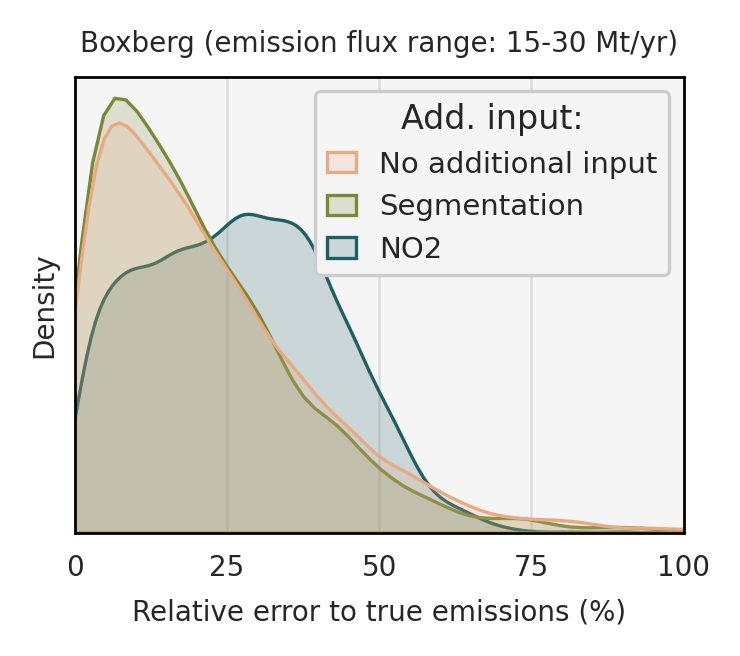

In [58]:
axs = mympf.set_figure_axs(
    1,
    1,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.2,
    pad_w_ext_right=0.2,
    pad_w_int=0.2,
    pad_h_ext=0.35,
    pad_h_int=0.25,
)
ax = axs[0]
sns.kdeplot(
    data=df_mape,
    x=first_col,
    common_norm=True,
    hue=second_col,
    fill=True,
    alpha=0.2,
    ax=ax,
    palette="cmc.batlowW_r",
)
ax.set_xticks([0, 25, 50, 75, 100])
ax.set_xlim(0, 100)
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_title("Boxberg (emission flux range: 15-30 Mt/yr)")
plt.savefig(os.path.join(dir_plots, "box_hist.png"), transparent=True)

# Histogram res Lippendorf

In [ ]:
path_eval_nc = "/libre/dumontj/coco2/dl-input/2km_Lip/train_dataset.nc"
path_valid_nc = "/libre/dumontj/coco2/dl-input/2km_forLip_2/valid_dataset.nc"
dir_res_box = os.path.join(dir_res, "inversion/inv_lip_sweep")

In [ ]:
name_model_0 = os.path.join(dir_res_box, "none_essential")
data_0 = model_eval.get_data_for_inversion(
    os.path.join(dir_res, name_model_0),
    path_eval_nc,
)

model_0 = model_eval.get_inversion_model(
    os.path.join(dir_res, name_model_0), name_w="w_best.h5"
)
metrics_0 = model_eval.get_inv_metrics_model_on_data(model_0, data_0)

197/197 [==============================] - 1s 4ms/step


In [ ]:
name_model_1 = os.path.join(dir_res_box, "perf_seg_essential")
data_1 = model_eval.get_data_for_inversion(
    os.path.join(dir_res, name_model_1),
    path_eval_nc,
)

model_1 = model_eval.get_inversion_model(
    os.path.join(dir_res, name_model_1), name_w="w_best.h5"
)
metrics_1 = model_eval.get_inv_metrics_model_on_data(model_1, data_1)

197/197 [==============================] - 1s 4ms/step


In [ ]:
name_model_2 = os.path.join(dir_res_box, "no2_essential")
data_2 = model_eval.get_data_for_inversion(
    os.path.join(dir_res, name_model_2),
    path_eval_nc,
)

model_2 = model_eval.get_inversion_model(
    os.path.join(dir_res, name_model_2), name_w="w_best.h5"
)
metrics_2 = model_eval.get_inv_metrics_model_on_data(model_2, data_2)

197/197 [==============================] - 1s 4ms/step


In [ ]:
first_col = "Relative error to true emissions (%)"
second_col = "Inputs:"
df_mape_0 = pd.DataFrame(
    {first_col: metrics_0["mape"], second_col: "xco2 fields, winds"}
)
df_mape_1 = pd.DataFrame({first_col: metrics_1["mape"], second_col: "+segmentation"})
df_mape_2 = pd.DataFrame({first_col: metrics_2["mape"], second_col: "+NO2"})
df_mape = pd.concat([df_mape_0, df_mape_1, df_mape_2])

In [ ]:
df_mape_2.describe()

,Relative error to true emissions (%)
count,6289.000000
mean,24.831778
std,22.387094
min,0.001552
25%,9.136260
50%,19.771309
75%,33.723007
max,288.961945


In [ ]:
mympf.setMatplotlibParam_singlefig()

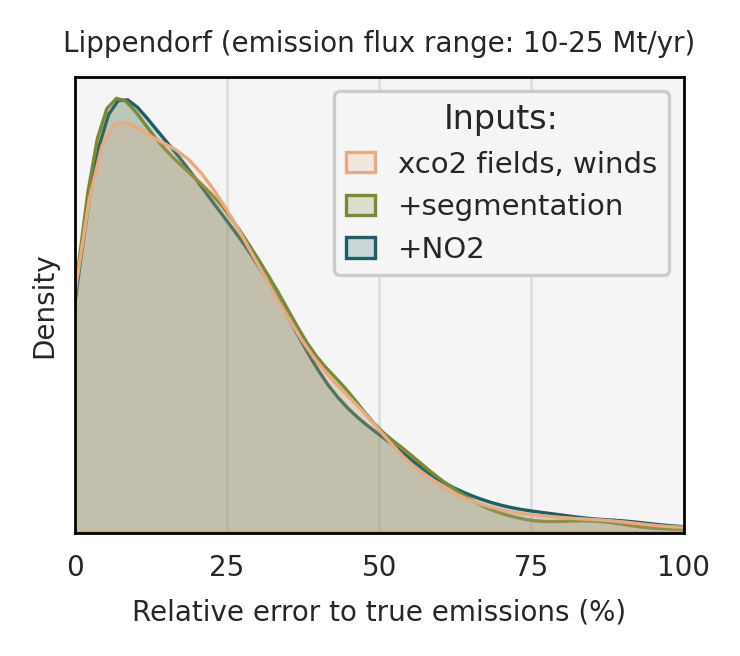

In [ ]:
axs = mympf.set_figure_axs(
    1,
    1,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.2,
    pad_w_ext_right=0.2,
    pad_w_int=0.2,
    pad_h_ext=0.35,
    pad_h_int=0.25,
)
ax = axs[0]
sns.kdeplot(
    data=df_mape,
    x=first_col,
    common_norm=True,
    hue=second_col,
    fill=True,
    alpha=0.2,
    ax=ax,
    palette="cmc.batlowW_r",
)
ax.set_xticks([0, 25, 50, 75, 100])
ax.set_xlim(0, 100)
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_title("Lippendorf (emission flux range: 10-25 Mt/yr)")
plt.savefig(os.path.join(dir_plots, "lip_hist.png"), transparent=True)

#  Inversion set-up 1

In [130]:
path_eval_nc = "/libre/dumontj/coco2/dl-input/2km_Box/train_dataset.nc"
path_valid_nc = "/libre/dumontj/coco2/dl-input/2km_forBox_2/valid_dataset.nc"
dir_res_box = os.path.join(dir_res, "inversion/inv_box_sweep")

In [131]:
name_model_1 = os.path.join(dir_res_box, "perf_seg_essential")
data_1 = model_eval.get_data_for_inversion(
    os.path.join(dir_res, name_model_1),
    path_eval_nc,
)

In [132]:
name_model_2 = os.path.join(dir_res_box, "no2_essential")
data_2 = model_eval.get_data_for_inversion(
    os.path.join(dir_res, name_model_2),
    path_eval_nc,
)

In [133]:
mympf.setMatplotlibParam_singlefig()
plt.viridis()

<Figure size 1200x900 with 0 Axes>

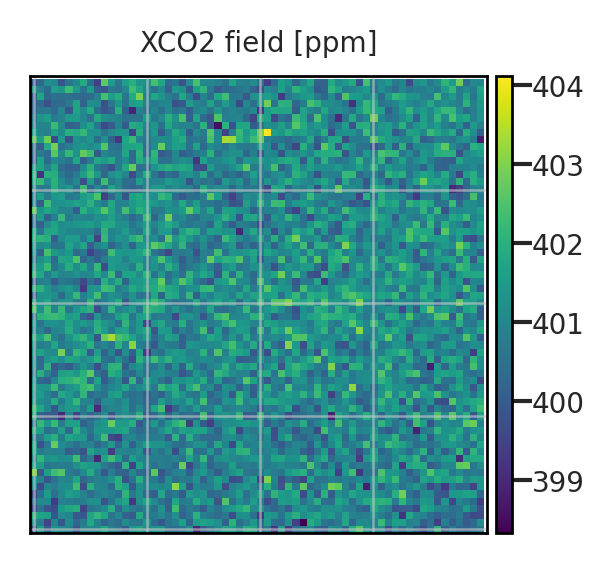

In [134]:
data = data_1
axs = mympf.set_figure_axs(
    1,
    1,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.2,
    pad_w_ext_right=0.2,
    pad_w_int=0.2,
    pad_h_ext=0.35,
    pad_h_int=0.25,
)
Ny = int(data.x.eval.shape[1])
Nx = int(data.x.eval.shape[2])
idx = 50
i_ax = 0
ax = axs[i_ax]
im = ax.imshow(np.squeeze(data.x.eval[idx, :, :, 0]), origin="lower")
cax = ax.inset_axes((1.02, 0, 0.035, 1))
cbar = plt.colorbar(im, cax, orientation="vertical")
ax.set_xticks([0, int(Ny / 4), int(Ny / 2), int(Ny * 3 / 4), Ny])
ax.set_yticks([0, int(Nx / 4), int(Nx / 2), int(Nx * 3 / 4), Nx])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title("XCO2 field [ppm]")
plt.savefig(os.path.join(dir_plots, "box_xco2_input.png"), transparent=True)

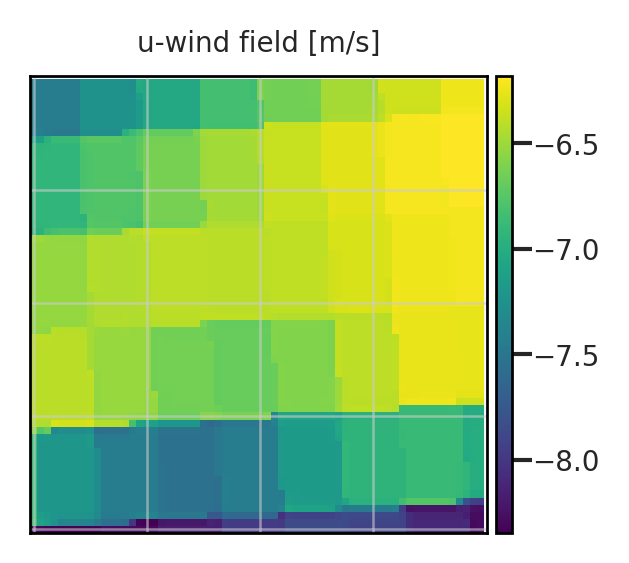

In [117]:
data = data_1
axs = mympf.set_figure_axs(
    1,
    1,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.2,
    pad_w_ext_right=0.2,
    pad_w_int=0.2,
    pad_h_ext=0.35,
    pad_h_int=0.25,
)
Ny = int(data.x.eval.shape[1])
Nx = int(data.x.eval.shape[2])
idx = 50
i_ax = 0
ax = axs[i_ax]
im = ax.imshow(np.squeeze(data.x.eval[idx, :, :, 2]), origin="lower")
cax = ax.inset_axes((1.02, 0, 0.035, 1))
cbar = plt.colorbar(im, cax, orientation="vertical")
ax.set_xticks([0, int(Ny / 4), int(Ny / 2), int(Ny * 3 / 4), Ny])
ax.set_yticks([0, int(Nx / 4), int(Nx / 2), int(Nx * 3 / 4), Nx])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title("u-wind field [m/s]")
plt.savefig(os.path.join(dir_plots, "box_wind_input.png"), transparent=True)

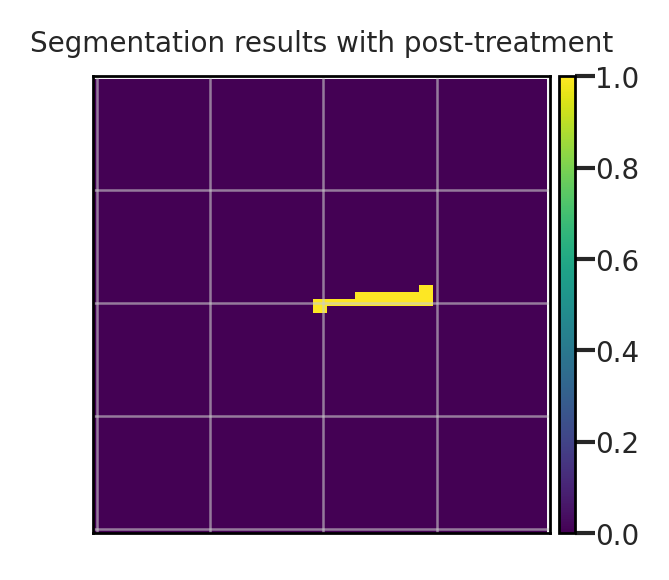

In [118]:
data = data_1
axs = mympf.set_figure_axs(
    1,
    1,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.2,
    pad_w_ext_right=0.2,
    pad_w_int=0.2,
    pad_h_ext=0.35,
    pad_h_int=0.25,
)
Ny = int(data.x.eval.shape[1])
Nx = int(data.x.eval.shape[2])
idx = 50
i_ax = 0
ax = axs[i_ax]
im = ax.imshow(np.squeeze(data.x.eval[idx, :, :, 4]), origin="lower")
cax = ax.inset_axes((1.02, 0, 0.035, 1))
cbar = plt.colorbar(im, cax, orientation="vertical")
ax.set_xticks([0, int(Ny / 4), int(Ny / 2), int(Ny * 3 / 4), Ny])
ax.set_yticks([0, int(Nx / 4), int(Nx / 2), int(Nx * 3 / 4), Nx])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title("Segmentation results with post-treatment")
plt.savefig(os.path.join(dir_plots, "box_seg_input.png"), transparent=True)

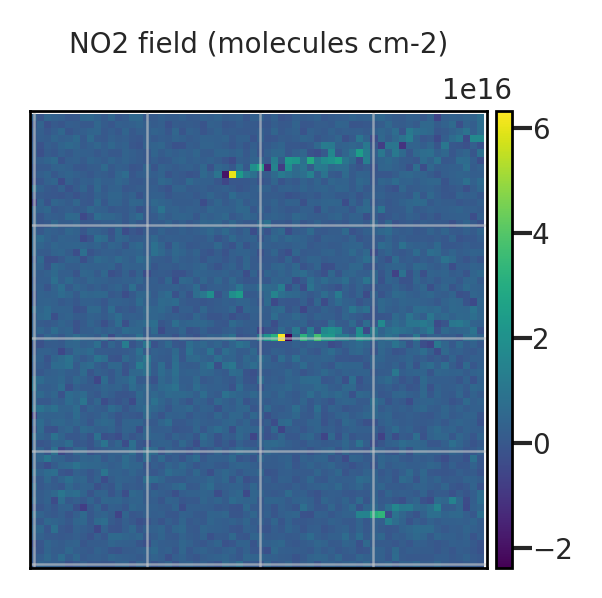

In [119]:
data = data_2
axs = mympf.set_figure_axs(
    1,
    1,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.2,
    pad_w_ext_right=0.2,
    pad_w_int=0.2,
    pad_h_ext=0.35,
    pad_h_int=0.25,
)
Ny = int(data.x.eval.shape[1])
Nx = int(data.x.eval.shape[2])
idx = 50
i_ax = 0
ax = axs[i_ax]
im = ax.imshow(np.squeeze(data.x.eval[idx, :, :, 4]), origin="lower")
cax = ax.inset_axes((1.02, 0, 0.035, 1))
cbar = plt.colorbar(im, cax, orientation="vertical")
ax.set_xticks([0, int(Ny / 4), int(Ny / 2), int(Ny * 3 / 4), Ny])
ax.set_yticks([0, int(Nx / 4), int(Nx / 2), int(Nx * 3 / 4), Nx])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title("NO2 field (molecules cm-2)")
plt.savefig(os.path.join(dir_plots, "box_no2_input.png"), transparent=True)

# Inversion set-up 2

In [ ]:
path_eval_nc = "/libre/dumontj/coco2/dl-input/2km_Box/train_dataset.nc"
path_valid_nc = "/libre/dumontj/coco2/dl-input/2km_forBox_2/valid_dataset.nc"
dir_res_box = os.path.join(dir_res, "inversion/inv_box_sweep")

In [ ]:
name_model_1 = os.path.join(dir_res_box, "perf_seg_essential")
data_1 = model_eval.get_data_for_inversion(
    os.path.join(dir_res, name_model_1),
    path_eval_nc,
)

In [ ]:
data = data_1
axs = mympf.set_figure_axs(
    1,
    1,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.2,
    pad_w_ext_right=0.2,
    pad_w_int=0.2,
    pad_h_ext=0.35,
    pad_h_int=0.25,
)
Ny = int(data.x.eval.shape[1])
Nx = int(data.x.eval.shape[2])
idx = 65
print(data.y.eval[idx])
i_ax = 0
ax = axs[i_ax]
im = ax.imshow(
    np.squeeze(Data.get_xco2_noiseless(data.ds)[idx, :, :, 0]), origin="lower"
)
cax = ax.inset_axes((1.02, 0, 0.035, 1))
cbar = plt.colorbar(im, cax, orientation="vertical")
ax.set_xticks([int(Ny / 4), int(Ny / 2), int(Ny * 3 / 4)])
ax.set_yticks([int(Nx / 4), int(Nx / 2), int(Nx * 3 / 4)])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel(f"Boxberg - emissions flux: {data.y.eval[idx][0]:.1f} Mt/yr")
ax.set_title("XCO2 field [ppm]")
plt.savefig(os.path.join(dir_plots, "box_xco2_noiseless.png"), transparent=True)

In [194]:
path_eval_nc = "/libre/dumontj/coco2/dl-input/2km_Pat/train_dataset.nc"
path_valid_nc = "/libre/dumontj/coco2/dl-input/2km_forPat_2/valid_dataset.nc"
dir_res_pat = os.path.join(dir_res, "inversion/inv_pat_sweep")

In [195]:
name_model_1 = os.path.join(dir_res_pat, "perf_seg_essential")
data_1 = model_eval.get_data_for_inversion(
    os.path.join(dir_res, name_model_1),
    path_eval_nc,
)

[5.36311007]


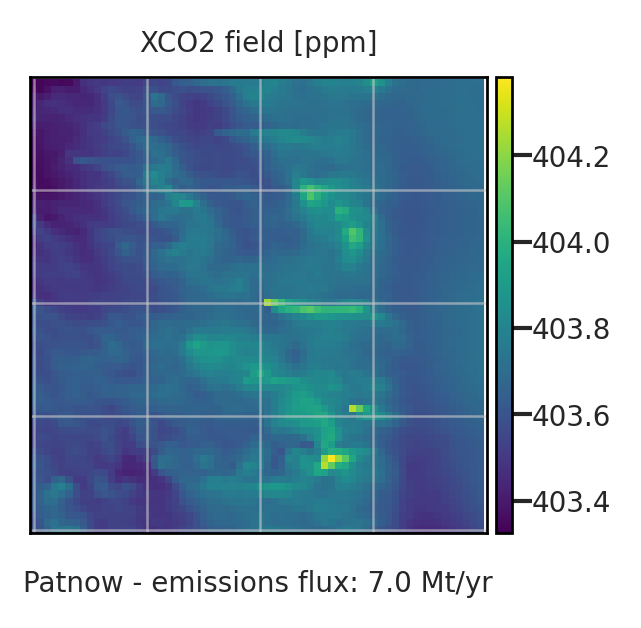

In [196]:
data = data_1
axs = mympf.set_figure_axs(
    1,
    1,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.2,
    pad_w_ext_right=0.2,
    pad_w_int=0.2,
    pad_h_ext=0.35,
    pad_h_int=0.25,
)
Ny = int(data.x.eval.shape[1])
Nx = int(data.x.eval.shape[2])
print(data.y.eval[idx])
idx = 1600
i_ax = 0
ax = axs[i_ax]
im = ax.imshow(
    np.squeeze(Data.get_xco2_noiseless(data.ds)[idx, :, :, 0]), origin="lower"
)
cax = ax.inset_axes((1.02, 0, 0.035, 1))
cbar = plt.colorbar(im, cax, orientation="vertical")
ax.set_xticks([0, int(Ny / 4), int(Ny / 2), int(Ny * 3 / 4), Ny])
ax.set_yticks([0, int(Nx / 4), int(Nx / 2), int(Nx * 3 / 4), Nx])
ax.set_xticklabels([])
ax.set_xlabel(f"Patnow - emissions flux: {data.y.eval[idx][0]:.1f} Mt/yr")
ax.set_yticklabels([])
ax.set_title("XCO2 field [ppm]")
plt.savefig(os.path.join(dir_plots, "pat_xco2_noiseless.png"), transparent=True)

# Data augmentation scaling

In [3]:
path_eval_nc = "/libre/dumontj/coco2/dl-input/2km_Lip/train_dataset.nc"
path_valid_nc = "/libre/dumontj/coco2/dl-input/2km_forLip_2/valid_dataset.nc"
dir_res_lip = os.path.join(dir_res, "lip/mae_lip")

In [4]:
name_model_1 = os.path.join(dir_res_lip, "best_no2")
data_1 = model_eval.get_data_for_inversion(
    os.path.join(dir_res, name_model_1),
    path_eval_nc,
)

In [5]:
idx = 500

[20.55495071]


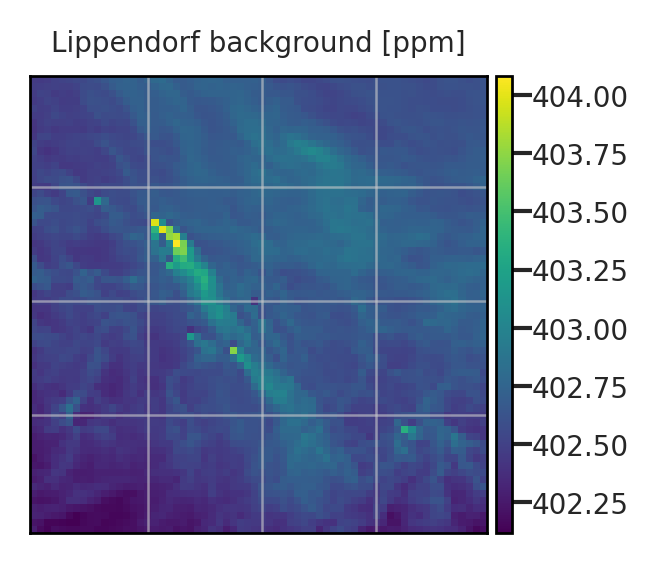

In [6]:
data = data_1
axs = mympf.set_figure_axs(
    1,
    1,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.01,
    pad_w_ext_right=0.15,
    pad_w_int=0.2,
    pad_h_ext=0.2,
    pad_h_int=0.25,
)
Ny = int(data.x.eval.shape[1])
Nx = int(data.x.eval.shape[2])
print(data.y.eval[idx])
idx = 700
i_ax = 0
ax = axs[i_ax]
data_plot = np.squeeze(Data.get_xco2_noiseless(data.ds)[idx, :, :, 0]) - np.squeeze(
    Data.get_plume(data.ds)[idx, :, :, 0]
)
im = ax.imshow(data_plot, origin="lower")
cax = ax.inset_axes((1.02, 0, 0.035, 1))
cbar = plt.colorbar(im, cax, orientation="vertical")
ax.set_xticks([int(Ny / 4), int(Ny / 2), int(Ny * 3 / 4)])
ax.set_yticks([int(Nx / 4), int(Nx / 2), int(Nx * 3 / 4)])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title("Lippendorf background [ppm]")
plt.savefig(os.path.join(dir_plots, "lip_background.png"), transparent=True)

[14.04304981]


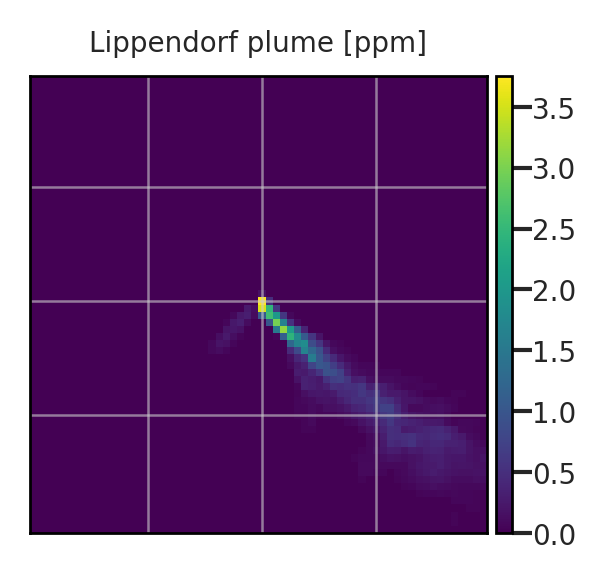

In [7]:
data = data_1
axs = mympf.set_figure_axs(
    1,
    1,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.01,
    pad_w_ext_right=0.15,
    pad_w_int=0.2,
    pad_h_ext=0.2,
    pad_h_int=0.25,
)
Ny = int(data.x.eval.shape[1])
Nx = int(data.x.eval.shape[2])
print(data.y.eval[idx])
idx = 700
i_ax = 0
ax = axs[i_ax]
data_plot = np.squeeze(Data.get_plume(data.ds)[idx, :, :, 0])
im = ax.imshow(data_plot, origin="lower")
cax = ax.inset_axes((1.02, 0, 0.035, 1))
cbar = plt.colorbar(im, cax, orientation="vertical")
ax.set_xticks([int(Ny / 4), int(Ny / 2), int(Ny * 3 / 4)])
ax.set_yticks([int(Nx / 4), int(Nx / 2), int(Nx * 3 / 4)])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title("Lippendorf plume [ppm]")
plt.savefig(os.path.join(dir_plots, "lip_plume.png"), transparent=True)

# Map locations all power plants

In [8]:
os.chdir("/cerea_raid/users/dumontj/dev/coco2/dl/nb_eval")

In [9]:
sys.path.append("/cerea_raid/users/dumontj/dev/coco2/data_build")
import coco2_data_config
import ddeq
import utils
import matplotlib_functions

matplotlib_functions.setMatplotlibParam()
plt.viridis()
from icecream import ic

<Figure size 1920x1440 with 0 Axes>

In [10]:
dir_raw_smartcarb_xco2_data = os.path.join(
    coco2_data_config.raw_data_dir, "smartcarb", "cosmo2D"
)


names_sources = [
    "Berlin",
    "Boxberg",
    "Janschwalde",
    "Lippendorf",
    "Turow",
    "Patnow",
    "Schwarze Pumpe",
    "Dolna Odra",
    "Opole",
]

sources = ddeq.misc.read_point_sources()
sc_coord = utils.get_raw_smartcarb_grid_coords()

In [60]:
year = 2015
month = np.random.choice(np.arange(1, 13))
day = np.random.choice(np.arange(1, 32))
hour = np.random.choice(np.arange(1, 24))

In [48]:
ic(month, day, hour)

ic| month: 5, day: 7, hour: 22


(5, 7, 22)

In [61]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

# Globally set text and label sizes
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12

In [62]:
cosmo_2d_file = os.path.join(
    dir_raw_smartcarb_xco2_data, f"cosmo_2d_{year:01}{month:02}{day:02}{hour:02}.nc"
)

ds = xr.open_dataset(
    cosmo_2d_file,
    decode_times=False,
)

XCO2_plume = ds.XCO2_BV.values[0] + ds.XCO2_JV.values[0] + ds.XCO2_A.values[0]
XCO2_bg = ds.XCO2_BG.values[0] + ds.XCO2_RA.values[0]

pres-inv/PP_locations.png


<Figure size 1920x1440 with 0 Axes>

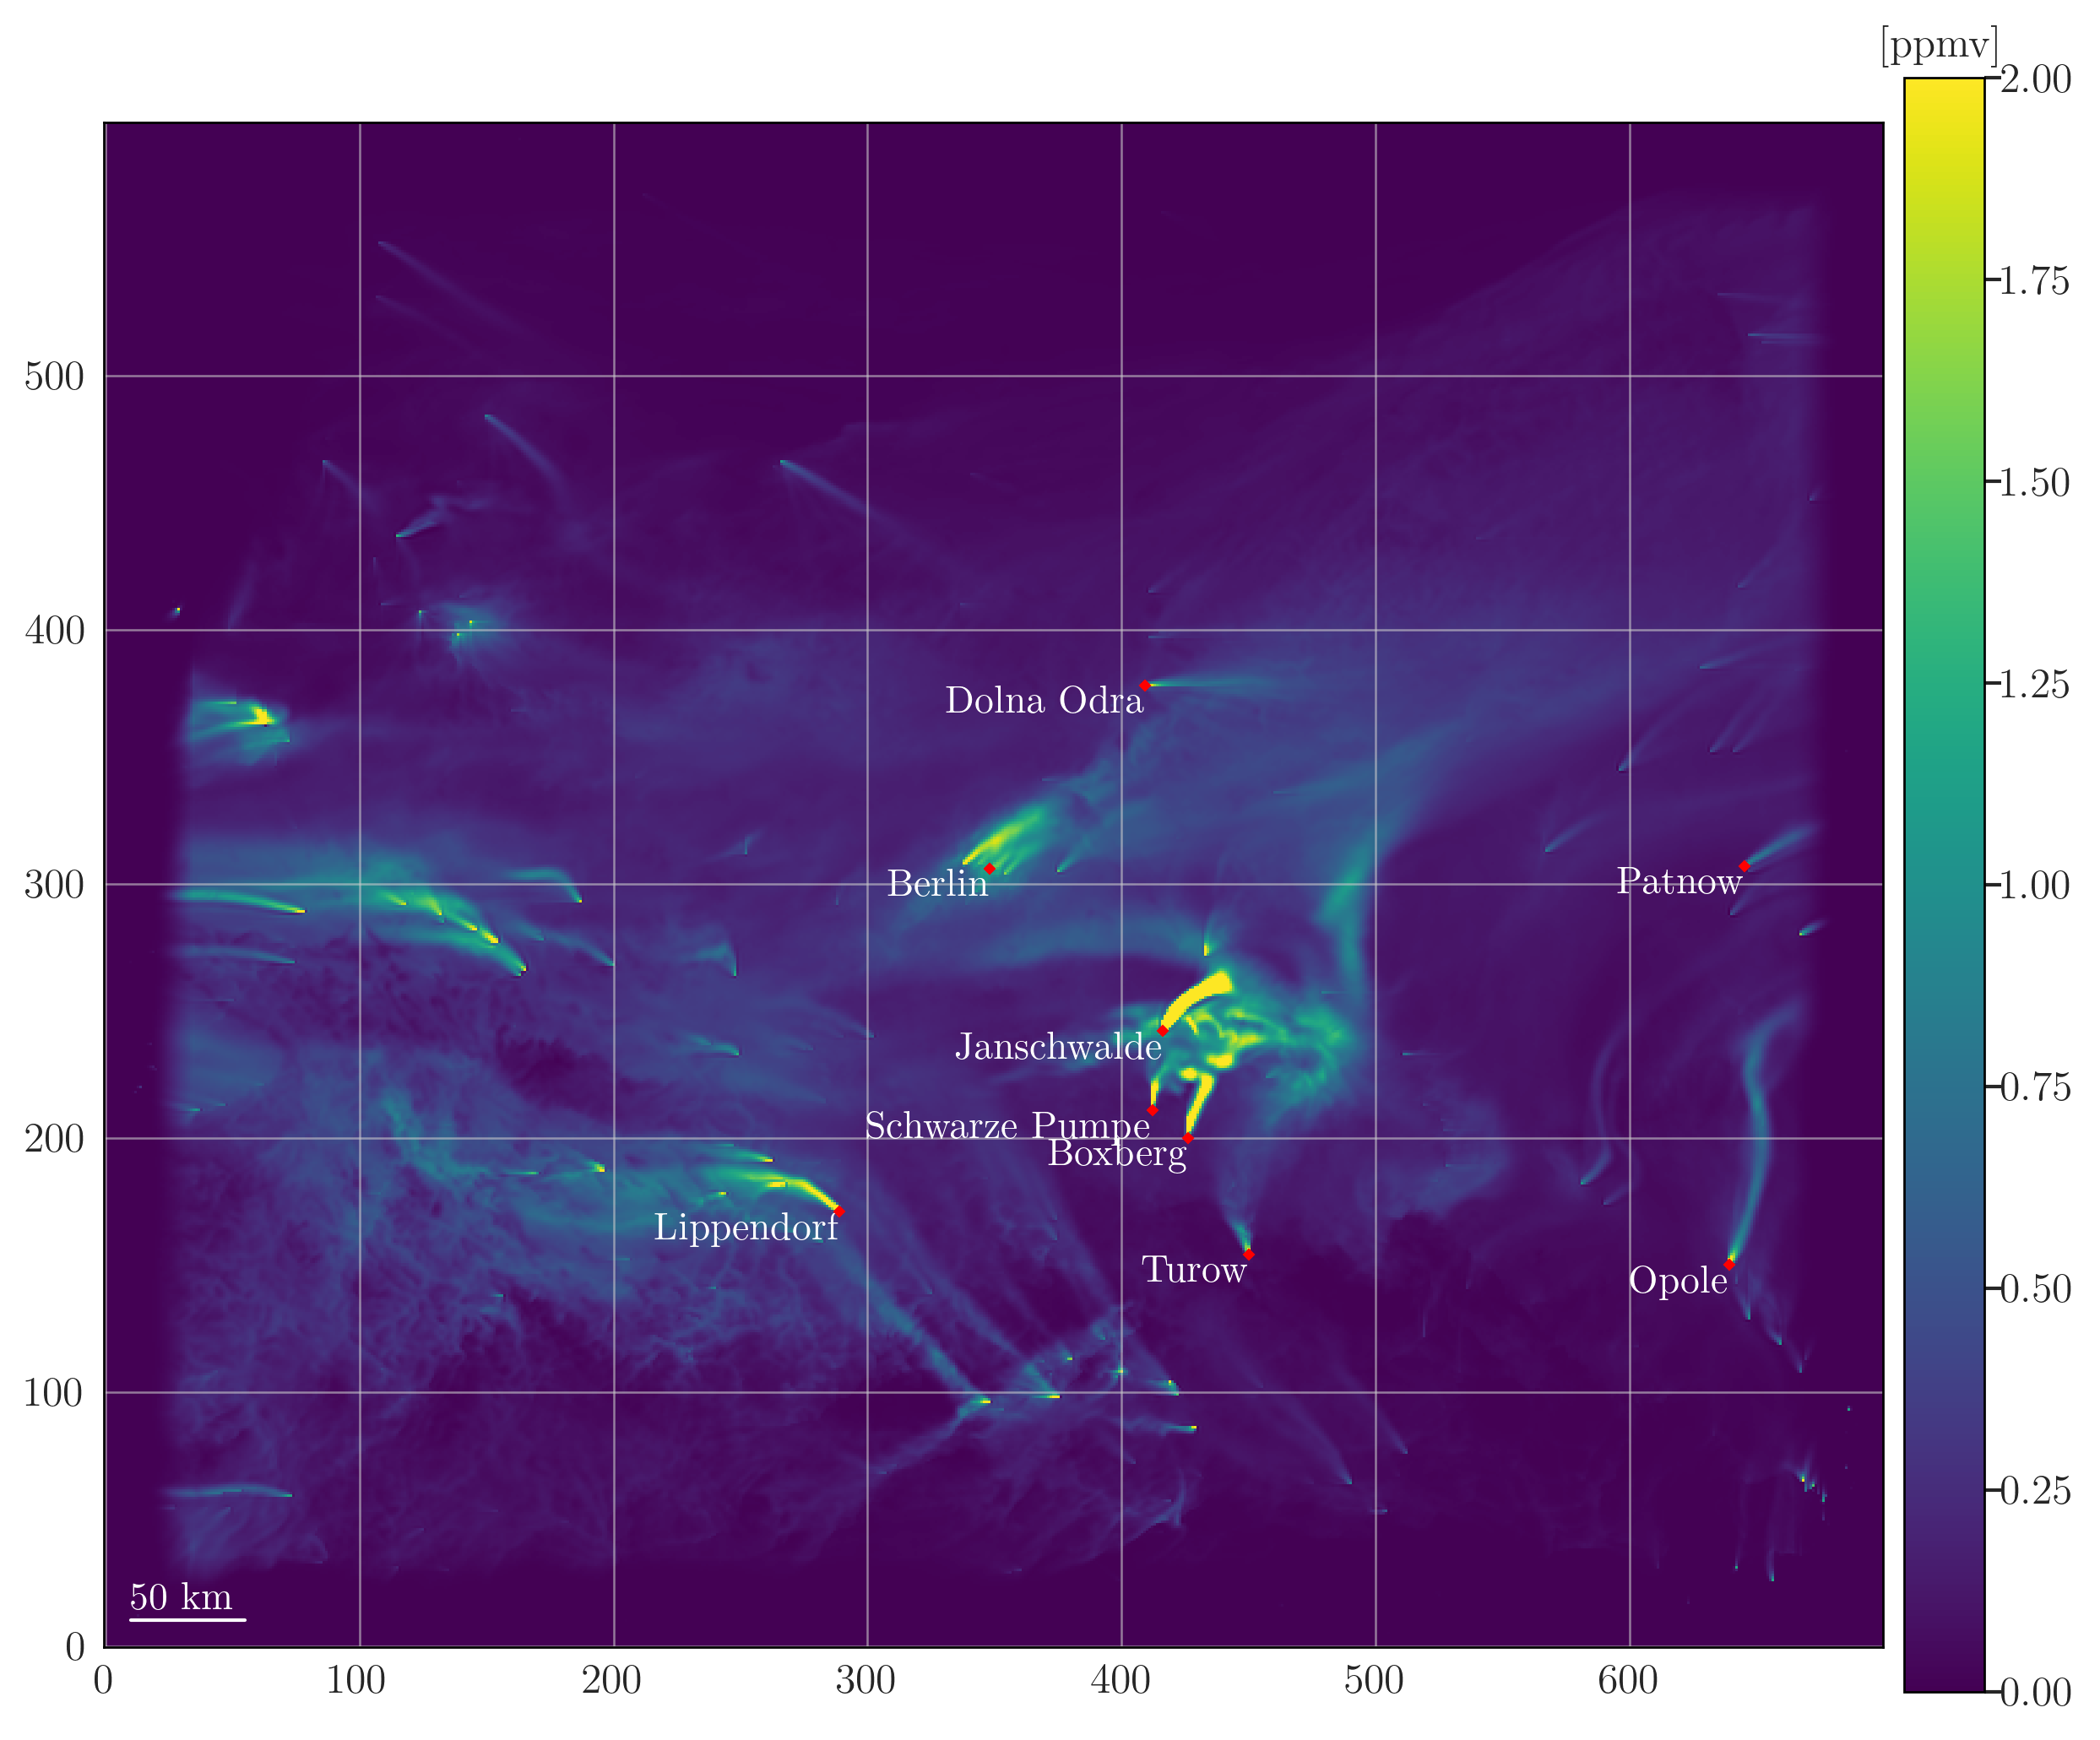

In [67]:
vmax = 1
plt.viridis()
fig, ax = plt.subplots(1, 1, figsize=(9, 7))
contour = plt.imshow(XCO2_plume, vmin=0, vmax=2, origin="lower")
# contour = plt.imshow(np.log(XCO2_plume), origin="lower")
cbar = fig.colorbar(contour, ax=ax, pad=0.01)
cbar.ax.set_title("[ppmv]", fontsize=12)

for name_source in names_sources:
    source_coords = utils.get_sc_source_coords(name_source)
    source_grid_point = utils.get_closest_grid_point_indices(sc_coord, source_coords)
    ax.plot(
        source_grid_point["x"],
        source_grid_point["y"],
        "D",
        markersize=2,
        color="red",
        label="_none_",
        zorder=10,
    )
    ax.annotate(
        name_source,
        xy=(source_grid_point["x"], source_grid_point["y"]),
        xytext=(0, -8),  # specify the offset in points
        textcoords="offset points",
        horizontalalignment="right",
        color="white",
        fontsize=11,
    )
scale_bar_length = 45  # in image units
scale_bar_pixel_length = 1  # length of the scale bar in pixels
scale_bar_color = "white"
ax.plot(
    [10, 10 + scale_bar_length],
    [10, 10],
    color=scale_bar_color,
    linewidth=scale_bar_pixel_length,
)
ax.text(10, 14, f"50 km", color=scale_bar_color, fontsize=11)


plt.tight_layout()  # Add this line to adjust margins
name_fig = os.path.join(dir_plots, f"PP_locations.png")
plt.savefig(name_fig, dpi=300, bbox_inches="tight", pad_inches=0.05, transparent=True)
print(name_fig)